In [2]:
import numpy as np

import jax
# import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from jax.config import config
# config.update("jax_debug_nans", True)
import jax.numpy as jnp
import jaxopt

import tinygp
from tinygp import GaussianProcess
from tinygp.kernels import quasisep
print(tinygp.__version__)

import eztao
from eztao.carma import DRW_term
from eztao.ts import gpSimRand
print(eztao.__version__)

import matplotlib.pyplot as plt

# config.update("jax_debug_nans", True) 

# https://github.com/google/jax/issues/5798

0.2.3.dev57+g60dde94
0.4.0


# Simulating DRW

In [3]:
# simulate stohastic component
# simulate DRW process via ezTao
amp = 0.25
tau = 78
DRW_kernel = DRW_term(np.log(amp), np.log(tau))
t, y, yerr = gpSimRand(DRW_kernel, 5, 365*10, 200)
true_t = np.linspace(0, 3600, 3600)
# get alpha and beta parameters - this is the input needed for tinygp
alpha_1, beta_0 = DRW_kernel.get_carma_parameter()
print('alpha_1, beta_0: ' + str(alpha_1) +','+ str(beta_0))

alpha_1, beta_0: 0.01282051282051282,0.0400320384512718


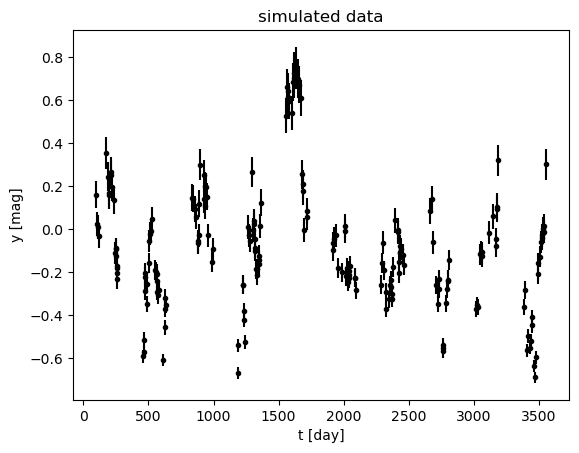

In [4]:
# visualize the simulated data
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("t [day]")
plt.ylabel("y [mag]")

_ = plt.title("simulated data")

In [5]:
# tinygp algorithm defined here - CARMA kernel
# create initial values
# multiplying the real valuswith 0.9 so that I am sure that
# I am not hitting exact values when searching for the solution
theta_drw_init = {   
     "alpha": alpha_1,
    "beta": beta_0
}

# 1. create Gaussian process - CARMA
def build_drw_gp(theta, t, y, yerr):
   
    carma_kernel = quasisep.CARMA.init(
        alpha=theta["alpha"], beta=theta["beta"]
    )
        
    return GaussianProcess(carma_kernel, t, diag=yerr, mean=np.mean(y))

# 2. create loss function
@jax.jit
def neg_log_likelihood_drw(theta, t, y, yerr):
    gp_drw = build_drw_gp(theta, t, y, yerr)
    return -gp_drw.log_probability(y)

# 3. evaluate in situ
obj_drw = jax.jit(jax.value_and_grad(neg_log_likelihood_drw))


print(f"Initial negative log likelihood: {obj_drw(theta_drw_init, t, y, yerr)[0]}")
print(
    f"Gradient of the negative log likelihood, \
    wrt the parameters:\n{obj_drw(theta_drw_init, t, y, yerr)[1]}"
)

Initial negative log likelihood: -42.111677870905716
Gradient of the negative log likelihood,     wrt the parameters:
{'alpha': DeviceArray(152.85469061, dtype=float64), 'beta': DeviceArray(295.72088893, dtype=float64)}


In [6]:
# tinygp algorithm defined here - exponential kernel
# these is the same as CARMA kernel in case of CARMA(1,0) process
theta_exp_init = {   
     "scale": tau*0.9,
    "sigma": amp*0.9
}

# 1. create Gaussian process - exp
def build_exp_gp(theta, t, y, yerr):
   
    exp_kernel = quasisep.Exp(
        scale=theta["scale"], sigma=theta["sigma"]
    )
        
    return GaussianProcess(exp_kernel, t, diag=yerr, mean=np.mean(y))

# 2. create loss function
@jax.jit
def neg_log_likelihood_exp(theta, t, y, yerr):
    gp_exp = build_exp_gp(theta, t, y, yerr)
    return -gp_exp.log_probability(y)

# 3. evaluate in situ
obj_exp = jax.jit(jax.value_and_grad(neg_log_likelihood_exp))


print(f"Initial negative log likelihood: {obj_exp(theta_exp_init, t, y, yerr)[0]}")
print(
    f"Gradient of the negative log likelihood, \
wrt the parameters:\n{obj_exp(theta_exp_init, t, y, yerr)[1]}"
)

Initial negative log likelihood: -42.189847595618744
Gradient of the negative log likelihood, wrt the parameters:
{'scale': DeviceArray(-0.10895968, dtype=float64, weak_type=True), 'sigma': DeviceArray(22.28060739, dtype=float64, weak_type=True)}


In [7]:
# create solvers, which search for the minimum
solver_drw = jaxopt.ScipyMinimize(fun=neg_log_likelihood_drw)
solver_exp = jaxopt.ScipyMinimize(fun=neg_log_likelihood_exp)

In [8]:
soln_exp = solver_exp.run(theta_exp_init, t=t, y=y, yerr=yerr)
soln_exp

OptStep(params={'scale': DeviceArray(155.92938479, dtype=float64), 'sigma': DeviceArray(0.24867889, dtype=float64)}, state=ScipyMinimizeInfo(fun_val=DeviceArray(-44.85502051, dtype=float64, weak_type=True), success=True, status=0, iter_num=19))

In [9]:
# final parameteres coming from exponent kernel
soln_exp.params

{'scale': DeviceArray(155.92938479, dtype=float64),
 'sigma': DeviceArray(0.24867889, dtype=float64)}

In [10]:
#  solution from exp kernel, tranformed into alpha and beta
DRW_kernel_solution = DRW_term(np.log(soln_exp.params['sigma']), np.log(soln_exp.params['scale']))
alpha_solution, beta_solution = DRW_kernel_solution.get_carma_parameter()
alpha_solution, beta_solution

(0.00641315940130269, 0.02816371434816185)

In [11]:
# final parameteres coming from CARMA kernel
# should be the same as alpha_solution and beta_solution
soln_drw = solver_drw.run(theta_drw_init, t=t, y=y, yerr=yerr)
soln_drw


OptStep(params={'alpha': DeviceArray(0.00641316, dtype=float64), 'beta': DeviceArray(0.02816371, dtype=float64)}, state=ScipyMinimizeInfo(fun_val=DeviceArray(-44.85502051, dtype=float64, weak_type=True), success=True, status=0, iter_num=9))

# Numpyro

In [12]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

ModuleNotFoundError: No module named 'numpyro'

In [ ]:
prior_sigma = .1
def numpyro_model_exp(t, yerr, y=None):
    scale = numpyro.sample("scale", dist.Normal(200,50))
    sigma = numpyro.sample("sigma", dist.Normal(0.3, 0.1))
    exp_kernel = quasisep.Exp(scale=scale, sigma=sigma)

    gp = GaussianProcess(exp_kernel, t, diag=yerr, mean=np.mean(y))
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)
    
    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, true_t).gp.loc)
        
        
def numpyro_model_drw(t, yerr, y=None):
    alpha = numpyro.sample("alpha", dist.HalfNormal(0.1))
    beta = numpyro.sample("beta", dist.HalfNormal(0.1))
    carma_kernel = quasisep.CARMA.init(
        alpha=alpha, beta=beta
    )
        
    gp =  GaussianProcess(carma_kernel, t, diag=yerr, mean=np.mean(y))

    numpyro.sample("gp", gp.numpyro_dist(), obs=y)
    
    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, true_t).gp.loc)

In [ ]:
nuts_kernel_exp = NUTS(numpyro_model_exp, dense_mass=True,
                       target_accept_prob=0.9)
nuts_kernel_drw = NUTS(numpyro_model_drw, dense_mass=True,
                       target_accept_prob=0.9)

mcmc_exp = MCMC(
    nuts_kernel_exp,
    num_warmup=2000,
    num_samples=1000,
    num_chains=2,
    progress_bar=False,
)

mcmc_drw = MCMC(
    nuts_kernel_drw,
    num_warmup=2000,
    num_samples=1000,
    num_chains=2,
    progress_bar=False,
)

rng_key = jax.random.PRNGKey(34923)

/tmp/ipykernel_70193/3273851312.py:6: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_exp = MCMC(
/tmp/ipykernel_70193/3273851312.py:14: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_drw = MCMC(


In [ ]:
%%time
mcmc_exp.run(rng_key, t, yerr, y=y)
samples_exp = mcmc_exp.get_samples()
pred_exp = samples_exp["pred"].block_until_ready()

mcmc_drw.run(rng_key, t, yerr, y=y)
samples_drw = mcmc_drw.get_samples()
pred_drw = samples_drw["pred"].block_until_ready()

CPU times: user 2min 55s, sys: 1min 7s, total: 4min 3s
Wall time: 1min 2s


In [ ]:
samples

{'pred': DeviceArray([[-0.0894791 , -0.08980726, -0.09013679, ...,  0.2240734 ,
                0.223094  ,  0.22211868],
              [-0.07452569, -0.07489139, -0.07525919, ...,  0.20218006,
                0.20095909,  0.1997451 ],
              [-0.07789005, -0.07825315, -0.07861822, ...,  0.20849629,
                0.20731051,  0.20613113],
              ...,
              [-0.07157009, -0.07196182, -0.07235609, ...,  0.2036976 ,
                0.20231704,  0.20094535],
              [-0.08140225, -0.08177044, -0.08214056, ...,  0.21788076,
                0.21668927,  0.21550399],
              [-0.08590086, -0.08626198, -0.08662484, ...,  0.22592725,
                0.2247898 ,  0.22365782]], dtype=float64),
 'scale': DeviceArray([239.6168101 , 174.17265789, 184.68415615, ..., 155.08000349,
              191.67602364, 207.88241308], dtype=float64),
 'sigma': DeviceArray([-0.16997634, -0.15538648, -0.16640404, ...,  0.21038592,
               0.21213181,  0.25100281], dtype=fl

In [ ]:
import arviz as az

data = az.from_numpyro(mcmc_exp)
az.summary(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
scale,188.709,44.452,105.394,267.711,5.167,3.668,75.0,1070.0,1.04
sigma,0.022,0.166,-0.186,0.230,0.116,0.098,3.0,113.0,1.83


In [ ]:
data = az.from_numpyro(mcmc_drw)
az.summary(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.009,0.004,0.002,0.017,0.0,0.0,1002.0,660.0,1.0
beta,0.021,0.004,0.013,0.029,0.0,0.0,955.0,1060.0,1.0


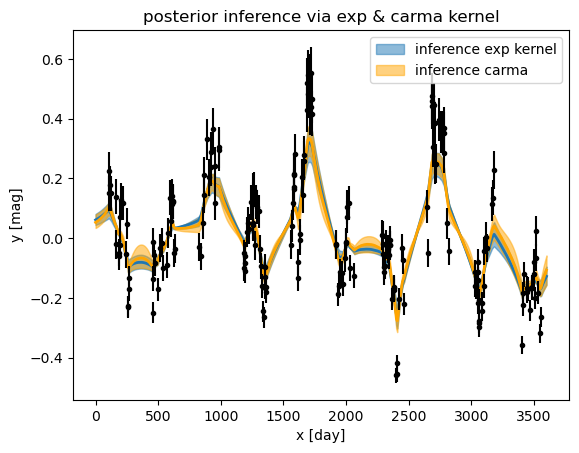

In [ ]:
q_exp = np.percentile(pred_exp, [5, 50, 95], axis=0)
plt.fill_between(true_t, q_exp[0], q_exp[2], color="C0", alpha=0.5,
                 label="inference exp kernel")
q_drw = np.percentile(pred_drw, [5, 50, 95], axis=0)
plt.fill_between(true_t, q_drw[0], q_drw[2], color="orange", alpha=0.5,
                 label="inference carma")

plt.plot(true_t, q_exp[1], color="C0", lw=2)
plt.plot(true_t, q_drw[1], color="orange", lw=2)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [mag]")

plt.legend()
_ = plt.title("posterior inference via exp & carma kernel")

# Fitting more complex model and find solution via grad 

In [13]:
# create more complex CARMA model 
# CARMA(2,0) in this case 
# the only difference is that we pass more parameters
# we call it DRW, but it is not DRW!
alpha_2 = 80 * alpha_1

theta_drw_init2 = {   
     "alpha": [alpha_1, alpha_2],
    "beta": beta_0
}

print(f"Initial negative log likelihood: {obj_drw(theta_drw_init2, t, y, yerr)[0]}")
print(
    f"Gradient of the negative log likelihood, \
    wrt the parameters:\n{obj_drw(theta_drw_init2, t, y, yerr)[1]}"
)

Initial negative log likelihood: -43.19609419531393
Gradient of the negative log likelihood,     wrt the parameters:
{'alpha': [DeviceArray(174.31295992, dtype=float64), DeviceArray(-10.55810153, dtype=float64)], 'beta': DeviceArray(232.06538692, dtype=float64)}


In [14]:
soln_drw2 = solver_drw.run(theta_drw_init2, t=t, y=y, yerr=yerr)
soln_drw2

OptStep(params={'alpha': [DeviceArray(0.00013055, dtype=float64), DeviceArray(0.01488019, dtype=float64)], 'beta': DeviceArray(0.00053949, dtype=float64)}, state=ScipyMinimizeInfo(fun_val=DeviceArray(-47.44003517, dtype=float64, weak_type=True), success=False, status=2, iter_num=17))

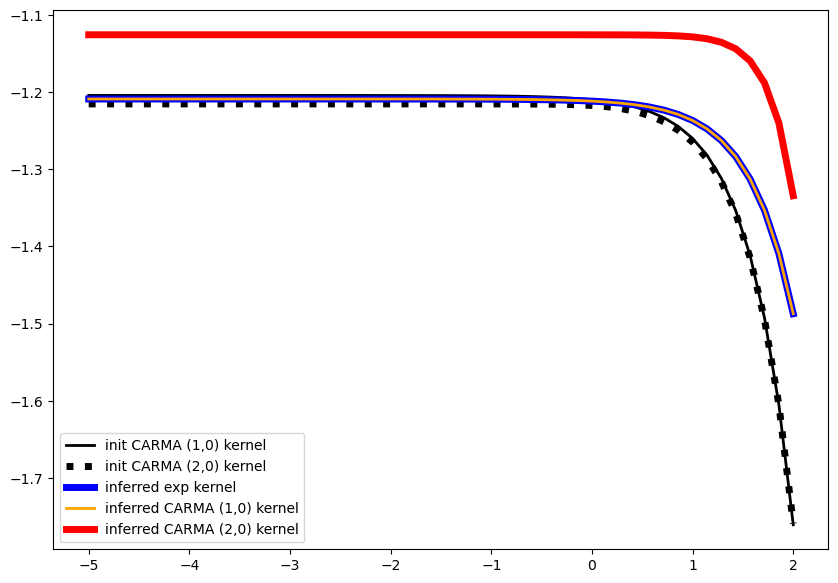

In [15]:
freq = np.logspace(-5, 2)
x = np.linspace(np.min(t)-10, np.max(t)+10, 2000)

# found parameters
gp_drw2 = build_drw_gp(soln_drw2.params, t, y, yerr)
gp_exp = build_exp_gp(soln_exp.params, t, y, yerr)
gp_drw = build_drw_gp(soln_drw.params, t, y, yerr)
# init parameters
gp_drw_init = build_drw_gp(theta_drw_init, t, y, yerr)
gp_drw_init2 = build_drw_gp(theta_drw_init2, t, y, yerr)

# mean and variance, for plotting on the data
cond_gp_drw = gp_drw.condition(y, x).gp
mu_drw, var_drw = cond_gp_drw.loc, cond_gp_drw.variance

cond_gp_drw2 = gp_drw2.condition(y, x).gp
mu_drw2, var_drw2 = cond_gp_drw2.loc, cond_gp_drw2.variance

plt.figure(figsize=(10,7))
plt.plot(np.log10(freq), np.log10(gp_drw_init.kernel(freq[:1], freq)[0]), 
            color='black', lw=2, label="init CARMA (1,0) kernel") 
plt.plot(np.log10(freq), np.log10(gp_drw_init2.kernel(freq[:1], freq)[0]), 
            color='black', ls=":", lw=5, label="init CARMA (2,0) kernel")       

plt.plot(np.log10(freq), np.log10(gp_exp.kernel(freq[:1], freq)[0]), 
            color='blue', lw=5, label="inferred exp kernel") 
plt.plot(np.log10(freq), np.log10(gp_drw.kernel(freq[:1], freq)[0]), 
            color='orange', lw=2, label="inferred CARMA (1,0) kernel") 
plt.plot(np.log10(freq), np.log10(gp_drw2.kernel(freq[:1], freq)[0]), 
            color='red', lw=5, label="inferred CARMA (2,0) kernel") 
 
# plt.ylim(-4, -1)
plt.legend()

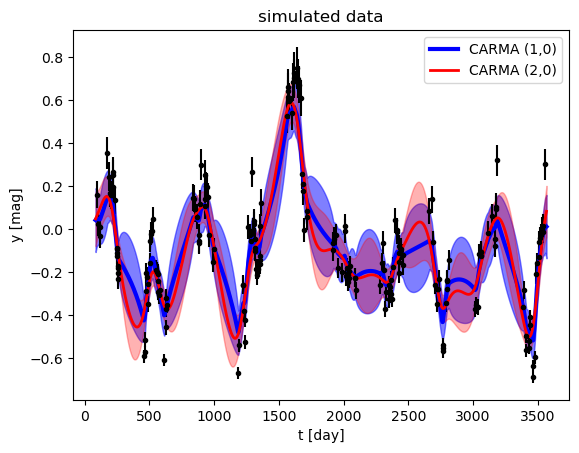

In [16]:
# plot both CARMA solutions
# how do I know if they are ok?
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("t [day]")
plt.ylabel("y [mag]")

_ = plt.title("simulated data")

plt.plot(x, mu_drw, color="blue", ls='-', lw=3, label = 'CARMA (1,0)')
plt.plot(x, mu_drw2, color="red", ls='-', lw=2, label = 'CARMA (2,0)')

plt.fill_between(x, mu_drw + np.sqrt(var_drw),
                 mu_drw- np.sqrt(var_drw), color="blue", alpha=0.5)
plt.fill_between(x, mu_drw2 + np.sqrt(var_drw2),
                 mu_drw2 - np.sqrt(var_drw2), color="red", alpha=0.3)

plt.legend()

# Complex example - compare with default solution 

number of points: 125


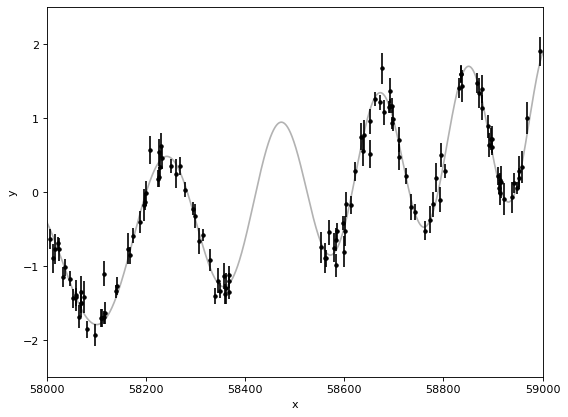

In [17]:
# let's simulate the data
# this is taken from the tinygp tutorial
np.random.seed(42)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  
# The input coordinates must be sorted
print('number of points: {}'.format(len(t)))
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 0+10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

t = t*100 + 58000
true_t = true_t*100 + 58000


plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(58000, 58000+10*100)
plt.ylim(-2.5, 2.5);

In [18]:
theta_init = {
    "log_per_amp": np.log(6.0),
    "log_scale": np.log(1.0),
    "log_sigma": np.log(4.3),
    "log_alpha": np.log([1.0, 1.2]),
    "log_beta": np.log([1.2])
}

def create_alt_theta_init(theta_init):

    alt_theta_init = {
        "log_per_amp": np.random.normal(np.exp(theta_init['log_per_amp']),
                                        np.exp(theta_init['log_per_amp'])),
        "log_scale": np.random.normal(np.exp(theta_init['log_scale']),
                                        np.exp(theta_init['log_scale'])),
        "log_sigma": np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma'])),
        "log_alpha": np.random.normal(np.exp(theta_init['log_alpha']),
                                        np.exp(theta_init['log_alpha'])),
        "log_beta": np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma']))}
    
    return alt_theta_init


# 1. combination of carma and periodic
def build_gp(theta, t):
    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    per_amp = jnp.exp(theta["log_per_amp"])
    
    carma_kernel = quasisep.CARMA.init(
        alpha=jnp.exp(theta["log_alpha"]), beta=jnp.exp(theta["log_beta"])
    )
    
    periodic_kernel = (
        per_amp
        * quasisep.Cosine(
            scale=jnp.exp(theta["log_scale"]),
            sigma=jnp.exp(theta["log_sigma"]),
        )
    )
    
    kernel = carma_kernel + periodic_kernel
    
    return GaussianProcess(kernel, t, diag=yerr, mean=0.0)

# 2. create loss function
@jax.jit
def neg_log_likelihood(theta, t, y):
    gp = build_gp(theta, t)
    return -gp.log_probability(y)

# 3. evaluate in situ
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: 162.81565860191517
Gradient of the negative log likelihood, wrt the parameters:
{'log_alpha': DeviceArray([19.89866069, -5.613459  ], dtype=float64), 'log_beta': DeviceArray([-16.693369], dtype=float64), 'log_per_amp': DeviceArray(0.99985759, dtype=float64), 'log_scale': DeviceArray(-4163.05934207, dtype=float64), 'log_sigma': DeviceArray(1.99971519, dtype=float64)}


In [19]:
# 4. optimize

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, t=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 159.9102868713867


In [20]:
# print parameters
soln.params

{'log_alpha': DeviceArray([-0.04414913,  0.20200243], dtype=float64),
 'log_beta': DeviceArray([0.21101972], dtype=float64),
 'log_per_amp': DeviceArray(1.78901124, dtype=float64),
 'log_scale': DeviceArray(0.34450078, dtype=float64),
 'log_sigma': DeviceArray(1.45311857, dtype=float64)}

In [21]:
# loop to find best value from many init
# around 1min 40seconds

list_fun_val = []
for i in range(1000):
    alt_theta_init = create_alt_theta_init(theta_init)
    soln = solver.run(alt_theta_init, t=t, y=y)
    list_fun_val.append([soln.state.fun_val.item(),soln.params])
    # print(f"Final negative log likelihood: {soln.state.fun_val}")
    
arr_fun_val = np.array(list_fun_val)

best_fun_val = np.min(arr_fun_val[:,0])
best_par = arr_fun_val[arr_fun_val[:,0] == best_fun_val][0][1]

# 4. optimize again from the best res 

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(best_par, t=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 42.070638716645206


(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3')])

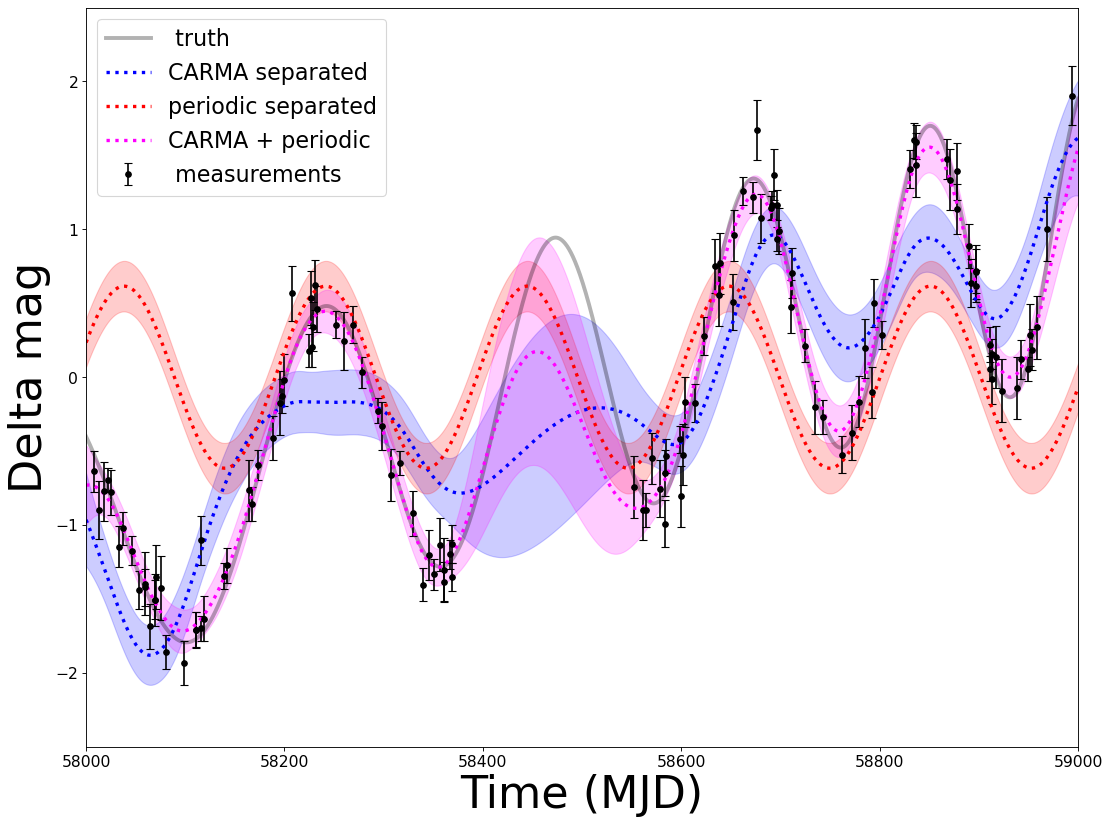

In [34]:
# define grid over which to evaluate
x = np.linspace(58000+0, 58000+10*100, 2000)


gp = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp
mu, var = cond_gp.loc, cond_gp.variance

mu_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.loc
var_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.variance

mu_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.loc
var_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.variance


plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(true_t, true_y, "k", lw=3.5, alpha=0.3, label = ' truth')
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements', ms=10)

plt.plot(x, mu_carma, color="blue", ls=':',lw=3, label = 'CARMA separated')
plt.plot(x, mu_periodic, color="red", ls=':', lw=3, label = 'periodic separated')

plt.fill_between(x, mu_carma + np.sqrt(var_carma),
                 mu_carma- np.sqrt(var_carma), color="blue", alpha=0.2)
plt.fill_between(x, mu_periodic + np.sqrt(var_periodic),
                 mu_periodic - np.sqrt(var_periodic), color="red", alpha=0.2)

plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="magenta", alpha=0.2)
plt.plot(x, mu, color="magenta", lw=3, ls=':', label = 'CARMA + periodic')

plt.xlabel("Time (MJD)", fontsize=40)
plt.ylabel("Delta mag", fontsize=40)
plt.xlim(58000, 58000+10*100)
plt.ylim(-2.5, 2.5);
plt.legend(fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# Continue 

In [ ]:
#

In [ ]:

import jax.numpy as jnp
from jax import grad, lax, custom_jvp

y = jnp.array([0.0])

@custom_jvp
def safe_sqrt(x):
    return jnp.sqrt(x)


@safe_sqrt.defjvp
def safe_sqrt_jvp(xpack, vpack):
    # inspired by https://github.com/google/jax/issues/5798
    x, = xpack
    v, = vpack
    f = safe_sqrt(x)
    print(x)
    df = v * lax.cond( jnp.any(x) > 0.0,
                       lambda x: 0.5/jnp.sqrt(x),
                       lambda x: jnp.array([0.0]),
                       x )
    print(f)
    print(df)
    df = df.item()
    return f, df

#################
df = grad(safe_sqrt)
print(df(y))
print(df(0.0)) 

#################
df = grad(jnp.sqrt)
print(df(y))
print(df(0.0))

[0.]
[0.]
Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)>


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)>
The problem arose with the `float` function. If trying to convert the data type of a value, try using `x.astype(float)` or `jnp.array(x, float)` instead.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [ ]:
test = jax.value_and_grad(jnp.sqrt)
test(jnp.array([2.0]))

TypeError: Gradient only defined for scalar-output functions. Output had shape: (1,).

In [ ]:
from jax import grad, lax, custom_jvp
import jax.numpy as jnp

@custom_jvp
def safe_sqrt(x):
    return jnp.sqrt(x)

@safe_sqrt.defjvp
def safe_sqrt_jvp(xprimals, xtan, vprimals, vtan):
    x, = xprimals
    v, = vprimals
    f = safe_sqrt(x)
    df = v * lax.cond(x > 0.0, lambda x: 0.5 / jnp.sqrt(x), lambda x: jnp.zeros_like(x), x)
    df *= xtan
    return (f, ), (df, )

In [ ]:
y = jnp.array([1e-9])
#################
df = grad(safe_sqrt)
print(df(y))
print(df(0.0)) 

#################
df = grad(jnp.sqrt)
print(df(y))
print(df(0.0))

TypeError: safe_sqrt_jvp() missing 2 required positional arguments: 'vprimals' and 'vtan'

In [ ]:
import jax.numpy as jnp

x = jnp.array([1.0, -2.0, 3.0])
lax.cond( jnp.any(x > 0.0), lambda x: x, lambda x: x, x )

DeviceArray([ 1., -2.,  3.], dtype=float64)

In [ ]:
x = 2
jnp.sqrt(x).astype(float)

DeviceArray(1.41421356, dtype=float64)

In [ ]:
import numpy as np

In [ ]:
np.sqrt(1**2 + 4)/2

1.118033988749895